# **Dobra, jakis tytul trzeba tu wymyślić** #

## **1. Basic imports** ##

In [73]:
import numpy as np
import pandas as pd
from enum import Enum
from abc import ABC, abstractmethod

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import ks_2samp, wasserstein_distance, spearmanr, anderson_ksamp
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon, cdist

from pyclustering.cluster.xmeans import xmeans, kmeans_plusplus_initializer # type: ignore

from river.datasets import synth
from river.drift import ADWIN
from river import evaluate, metrics, ensemble, drift, tree

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
import warnings

if not hasattr(np, "warnings"):
    np.warnings = warnings

## **2. Creating concept drift stream** ##

### **2.1. Different Concept Drift Generators** ###

#### **2.1.1. SEA** ####

Ten generator jest fajny, ale trzeba zmienić variant zeby były rózne. Inaczej wygeneują się dwa niemal identyczne strumienie.

In [3]:
stream_SEA = synth.ConceptDriftStream(
    stream=synth.SEA(seed=42, variant=0),
    drift_stream=synth.SEA(seed=42, variant=3),
    position=500,
    width=10,
    seed=1
)

#### **2.1.2. Hyperplane** ####

In [4]:
# stream_Hyperplane = synth.ConceptDriftStream(
#     stream=synth.Hyperplane(n_features=2, seed=42),
#     drift_stream=synth.Hyperplane(n_features=2,noise_percentage=0.0, mag_change=0.01, seed=42),
#     position=500,
#     width=100,
#     seed=1
# )

In [5]:
stream_Hyperplane = synth.Hyperplane(
    n_features=2,
    noise_percentage=0.0,
    mag_change=0.01,
    seed=42
)

#### **2.1.3. RandomRBF** ####

To jest trochę crazy i coś tam coś tam ze jakies centroidy, ale nie wygląda to tak ładnie jak SEA

In [6]:

stream_RBF = synth.ConceptDriftStream(
    stream=synth.RandomRBF(n_features=2),
    drift_stream=synth.RandomRBF(n_features=2),
    position=500,
    width=10,
    seed=1
)

### **2.2. Visualization of data drift** ###

In [7]:
def visualize_drift(stream, n):
    """
    Visualizes the data points before and after a concept drift in a 2D feature space.

    Parameters:
    - stream: A data stream object that yields (features, label) tuples.
    - n: Total number of samples to take from the stream for visualization. Drift starts at n/2.
    """
    X, y = [], []
    for x, label in stream.take(n):
        X.append(x)
        y.append(label)

    # Convert to lists of features
    f1 = [row[0] for row in X]
    f2 = [row[1] for row in X]

    # Plot before and after drift
    plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plt.scatter(f1[:n//2], f2[:n//2], c=y[:n//2], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("Before Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    # After drift
    plt.subplot(1, 2, 2)
    plt.scatter(f1[n//2:], f2[n//2:], c=y[n//2:], cmap="coolwarm", s=20, alpha=0.7)
    plt.title("After Drift")
    plt.xlabel("att0")
    plt.ylabel("att1")

    plt.tight_layout()
    plt.show()

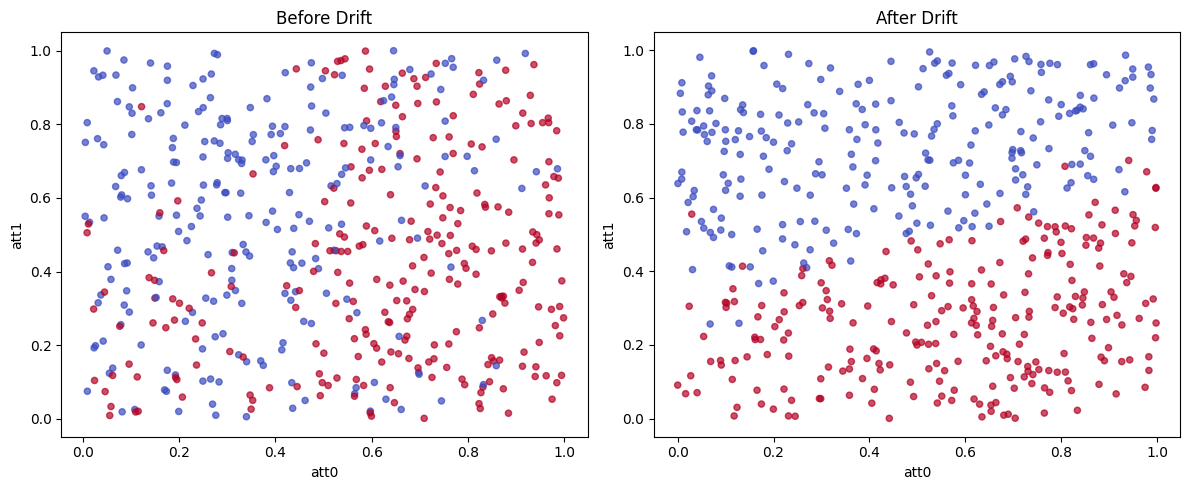

In [8]:
visualize_drift(stream_Hyperplane, 1000)

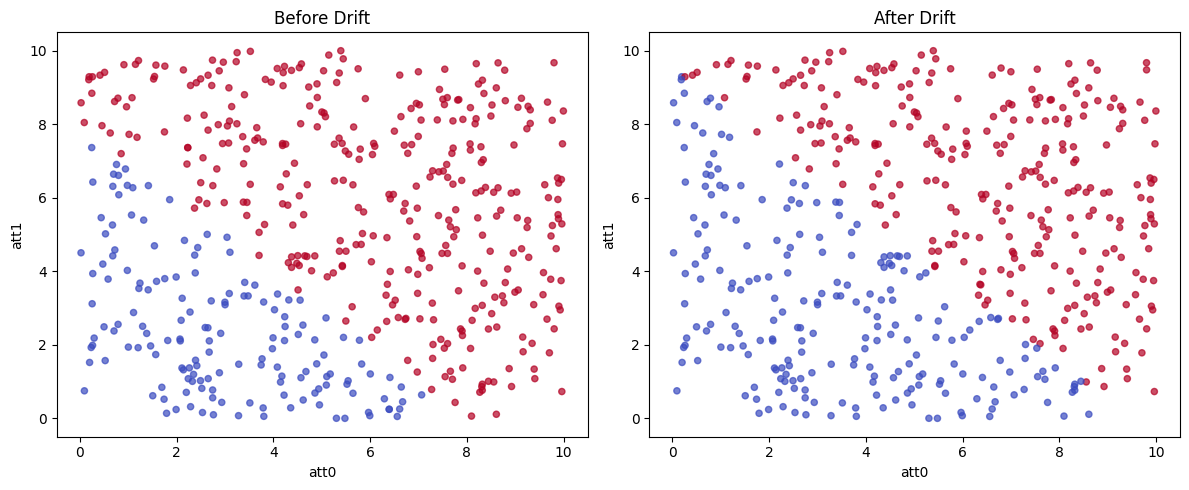

In [9]:
visualize_drift(stream_SEA, 1000)

## **3. Data scaling + other helpers**

### **3.1. Data normalization** ##

May be necessary later

In [10]:
class ScalingType(Enum):
    MinMax = 'min_max'
    Standardization = 'standardization'

def transform_dict_to_list(stream, n_samples=1000):
    X, y = [], []
    for x, label in stream.take(n_samples):
        X.append(list(x.values()))
        y.append(label)
    return X, y

class DataScaler:
    def __init__(self, scaling_type):
        if scaling_type==ScalingType.MinMax:
            self.scaler = MinMaxScaler()
        elif scaling_type==ScalingType.Standardization:
            self.scaler = StandardScaler()
        else:
            raise ValueError("Unsupported scaling type")

    def fit(self, X):
        X_df = pd.DataFrame(X)
        self.scaler.fit(X_df)
        
    def transform(self, X): # one scaler can be fitted once but used many times
        X_df = pd.DataFrame(X)
        return self.scaler.transform(X_df)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [11]:
X, y = transform_dict_to_list(stream_SEA, 1000)
X_before, X_after = X[:500], X[500:]
y_before, y_after = y[:500], y[500:]

data_scaler = DataScaler(ScalingType.Standardization)
X_before_scaled = data_scaler.fit_transform(X_before)
X_after_scaled = data_scaler.transform(X_after)

### **3.2. Data dimensions reducer for plotting multidimensional data**
For plotting purposes

In [12]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.decomposition import FastICA, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from umap import UMAP


class ReducerType(Enum):
    # For linear data
    PCA = 'PCA'
    ICA = 'ICA'
    FA = 'FA'
    LDA = 'LDA'

    # Non-linear
    TSNE = 't_SNE'
    UMAP = 'UMAP'
    LLE = 'LLE'
    MDS = 'MDS'
    # Autoencoders/Isomap/kernel PCA could be added here

class DataDimensionsReducer:
    def __init__(self):
        self.reducer = None

    def reduce(self, reducer_type, data):
        return getattr(self, f"reduce_{reducer_type.value}")(data)
    
    def _reduce(self, data, reducer):
        if self.reducer is not None:
            reduced_data = self.reducer.transform(data)
        else:
            self.reducer = reducer
            reduced_data = self.reducer.fit_transform(data)
        return reduced_data

    def reduce_PCA(self, data):
        return self._reduce(data, PCA(n_components=2))

    def reduce_ICA(self, data):
        return self._reduce(data, FastICA(n_components=2))

    def reduce_FA(self, data):
        return self._reduce(data, FactorAnalysis(n_components=2))

    def reduce_LDA(self, data):
        return self._reduce(data, LDA(n_components=2))

    def reduce_t_SNE(self, data):
        return self._reduce(data, TSNE(n_components=2))

    def reduce_UMAP(self, data):
        return self._reduce(data, UMAP(n_components=2))

    def reduce_LLE(self, data):
        return self._reduce(data, LocallyLinearEmbedding(n_components=2, n_neighbors=15))

    def reduce_MDS(self, data):
        return self._reduce(data, MDS(n_components=2))

In [210]:
drift_10d = synth.ConceptDriftStream(
    stream=synth.Hyperplane(n_features=10, seed=42),
    drift_stream=synth.Hyperplane(n_features=10, seed=42),
    position=500,
    width=10,
    seed=1
)
X_10d, y = transform_dict_to_list(drift_10d, 1000)
X_2d = DataDimensionsReducer().reduce(ReducerType.PCA, X_10d)

### **3.3. Data plotting** ###

In [218]:
def plot_data(X, y, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=20, alpha=0.7)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def plot_drift(X_before, y_before, X_after, y_after, show = True):
    plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plt.scatter(X_before[:, 0], X_before[:, 1], c=y_before, cmap="coolwarm", s=20, alpha=0.7)
    plt.title('Before')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # After drift
    plt.subplot(1, 2, 2)
    plt.scatter(X_after[:, 0], X_after[:, 1], c=y_after, cmap="coolwarm", s=20, alpha=0.7)
    plt.title('After')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    plt.tight_layout()
    if show:
        plt.show()

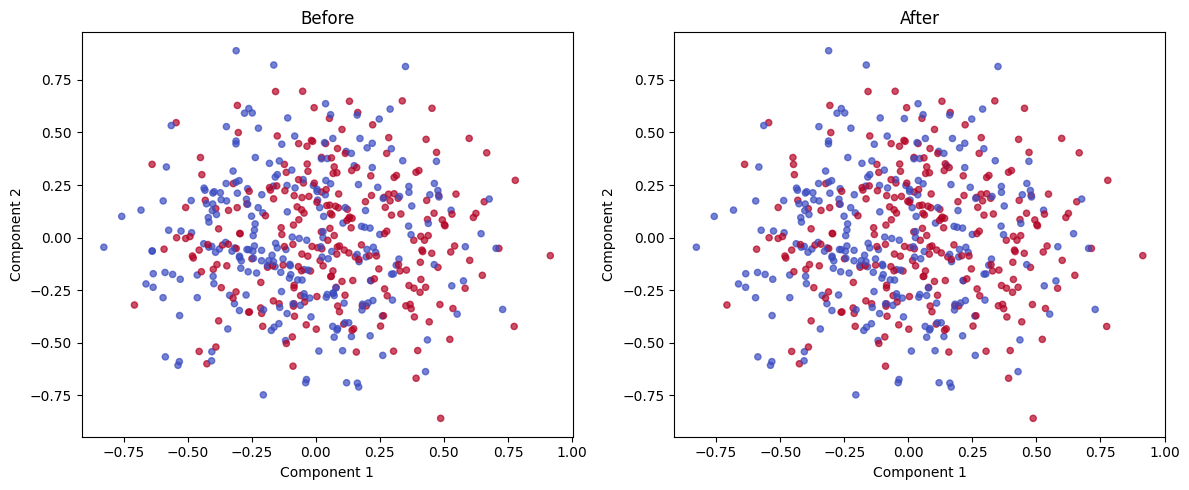

In [219]:
plot_drift(X_2d[:500], y[:500], X_2d[500:], y[500:])

## **4. Drift detection using descriptive statistics**

In [213]:
class StatisticsType(Enum):
    Mean = 'mean'
    StandardDeviation = 'sd'
    Min = 'min'
    Max = 'max'
    Median = 'median'
    ImbalanceRatio = 'imbalance_ratio'
    All = 'all' # TODO: implement all

class DriftDetector(ABC):
    def detect(self):
        pass

class DescriptiveStatisticsDriftDetector(DriftDetector):
    def __init__(self):
        pass

    def calculate_range(self, old_value, new_value, thr):
        if old_value == 0 and new_value == 0:
            return False
        elif old_value == 0 and new_value != 0:
            return True
        elif abs(new_value - old_value)/abs(old_value) > thr:
            return True
        return False

    def detect_mean(self, old_data, new_data, thr):
        old_mean = old_data.groupby('label').mean().T
        new_mean = new_data.groupby('label').mean().T

        assert old_mean.shape == new_mean.shape
        for label in old_mean.columns:
            for feature in old_mean.index:
                if self.calculate_range(old_mean.at[feature, label], new_mean.at[feature, label], thr):
                    return True
        return False

    def detect_median(self, old_series, new_series, thr):
        old_median = old_series.groupby('label').median().T
        new_median = new_series.groupby('label').median().T
        
        assert old_median.shape == new_median.shape
        for label in old_median.columns:
            for feature in old_median.index:
                if self.calculate_range(old_median.at[feature, label], new_median.at[feature, label], thr):
                    return True
        return False

    def detect_sd(self, old_data, new_data, thr):
        old_sd = old_data.groupby('label').std().T
        new_sd = new_data.groupby('label').std().T

        assert old_sd.shape == new_sd.shape
        for label in old_sd.columns:
            for feature in old_sd.index:
                if self.calculate_range(old_sd.at[feature, label], old_sd.at[feature, label], thr):
                    return True
        return False

    def detect_min(self, old_data, new_data, thr):
        old_min = old_data.groupby('label').min().T
        new_min = new_data.groupby('label').min().T
        
        assert old_min.shape == new_min.shape
        for label in old_min.columns:
            for feature in old_min.index:
                if self.calculate_range(old_min.at[feature, label], new_min.at[feature, label], thr):
                    return True
        return False

    def detect_max(self, old_data, new_data, thr):
        old_max = old_data.groupby('label').max().T
        new_max = new_data.groupby('label').max().T
        
        assert old_max.shape == new_max.shape
        for label in old_max.columns:
            for feature in old_max.index:
                if self.calculate_range(old_max.at[feature, label], new_max.at[feature, label], thr):
                    return True
        return False
    
    def detect_imbalance_ratio(self, old_data, new_data, thr):
        old_ir = old_data['label'].value_counts(normalize=True)
        new_ir = new_data['label'].value_counts(normalize=True)

        assert old_ir.shape == new_ir.shape
        for label in old_ir.index:
            if self.calculate_range(old_ir.at[label], new_ir.at[label], thr):
                return True
        return False
    
    def _detect_single_statistic(self, old_data, new_data, stat_type, thr):
        if stat_type == StatisticsType.Mean:
            return self.detect_mean(old_data, new_data, thr)
        elif stat_type == StatisticsType.StandardDeviation:
            return self.detect_sd(old_data, new_data, thr)
        elif stat_type == StatisticsType.Min:
            return self.detect_min(old_data, new_data, thr)
        elif stat_type == StatisticsType.Max:
            return self.detect_max(old_data, new_data, thr)
        elif stat_type == StatisticsType.Median:
            return self.detect_median(old_data, new_data, thr)
        elif stat_type == StatisticsType.ImbalanceRatio:
            return self.detect_imbalance_ratio(old_data, new_data, thr)
        else:
            raise ValueError("Unsupported statistics type")

    def detect(self, old_data, new_data, stat_type, features=None, thr=0.2):
        if features is not None:
            old_data = old_data[features]
            new_data = new_data[features]

        if type(stat_type) is list:
            drifts = []
            for st in stat_type:
                drifts.append(self._detect_single_statistic(old_data, new_data, st, thr))
            return sum(drifts)/len(drifts) > 0.4
        else:
            return self._detect_single_statistic(old_data, new_data, stat_type, thr)

In [214]:
def transform_lists_to_df(X, y):
    X_df = pd.DataFrame(X)
    y_series = pd.Series(y)
    data = pd.concat([X_df, y_series], axis=1)
    data.columns = [f'feature{i}' for i in range(X_df.shape[1])] + ['label']
    return data

In [215]:
data_before = transform_lists_to_df(X_before, y_before)
data_after = transform_lists_to_df(X_after, y_after)

DSDD = DescriptiveStatisticsDriftDetector()
print(DSDD.detect(data_before, data_after, StatisticsType.Mean))
print(DSDD.detect(data_before, data_after, StatisticsType.Min))
print(DSDD.detect(data_before, data_after, StatisticsType.Max))
print(DSDD.detect(data_before, data_after, StatisticsType.Median))
print(DSDD.detect(data_before, data_after, StatisticsType.StandardDeviation))
print(DSDD.detect(data_before, data_after, StatisticsType.ImbalanceRatio))
print(DSDD.detect(data_before, data_after, [
    StatisticsType.Mean,
    StatisticsType.Min,
    StatisticsType.Max,
    StatisticsType.Median,
    StatisticsType.StandardDeviation,
    StatisticsType.ImbalanceRatio
]))

False
True
False
False
False
False
False


## **5. Drift detection using statistical tests**

In [216]:
class StatisticalTestType(Enum):
    KolmogorovSmirnov = 'kolmogorov_smirnov_test'
    KullbackLeibler = 'kullback_leibler_divergence'
    WassersteinDistance = 'wasserstein_distance'
    JensenShannon = 'jensen_shannon_divergence'
    Spearman = 'spearman_correlation_coefficient'
    AD = 'ad'
    CHI2 = 'chi2'

class StatisticalTestsDriftDetector(DriftDetector):
    def __init__(self):
        pass

    def detect_kolmogorov_smirnov(self, old_data, new_data, alpha=0.05):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                stat, p_value = ks_2samp(old_data[old_data.label == l][column], new_data[new_data.label == l][column])
                if p_value < alpha:
                    return True
        return False

    def detect_kullback_leibler(self, old_data, new_data, thr=0.1, bins=30):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                old_dist = np.histogram(old_data[old_data.label == l][column], bins=bins, density=True)[0] + 1e-10
                new_dist = np.histogram(new_data[new_data.label == l][column], bins=bins, density=True)[0] + 1e-10

                old_dist /= old_dist.sum()
                new_dist /= new_dist.sum()

                kl_div = sum(rel_entr(old_dist, new_dist))
                if kl_div > thr:
                    # print("Drift detected in feature {} and label {}".format(column, l))
                    return True
        return False

    def detect_wasserstein(self, old_data, new_data, thr=0.1):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                wd = wasserstein_distance(old_data[old_data.label==l][column], new_data[new_data.label==l][column])
                if wd > thr:
                    return True
        return False

    def detect_jensen_shannon(self, old_data, new_data, thr=0.1):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                old_dist = np.histogram(old_data[old_data.label==l][column], bins=30, density=True)[0] + 1e-10
                new_dist = np.histogram(new_data[new_data.label==l][column], bins=30, density=True)[0] + 1e-10
                js_div = jensenshannon(old_dist, new_dist)
                if js_div > thr:
                    return True
        return False

    def detect_spearman(self, old_data, new_data, thr=0.5):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue      
                min_len = min(len(old_data[old_data.label==l][column]), len(new_data[new_data.label==l][column])) # sizes of distribution must be the same
                old_sample = old_data[old_data.label==l][column].sample(min_len, random_state=42)
                new_sample = new_data[new_data.label==l][column].sample(min_len, random_state=42)

                corr, _ = spearmanr(old_sample, new_sample)
                if abs(corr) < thr:
                    return True
        return False

    def detect_ad(self, old_data, new_data, alpha=0.05):
        labels = sorted(list(set(old_data['label']).union(set(new_data['label']))))
        for l in labels:
            for column in old_data.columns:
                if column == 'label':
                    continue
                stat, critical, sig = anderson_ksamp([old_data[old_data.label==l][column], new_data[new_data.label==l][column]])
                if sig < alpha:
                    return True
        return False

In [217]:
STDD = StatisticalTestsDriftDetector()
print(STDD.detect_kolmogorov_smirnov(data_before, data_after))
print(STDD.detect_kullback_leibler(data_before, data_after))
print(STDD.detect_wasserstein(data_before, data_after))
print(STDD.detect_jensen_shannon(data_before, data_after))
print(STDD.detect_spearman(data_before, data_after))
print(STDD.detect_ad(data_before, data_after))

True
False
False
True
True
True


## **6. Drift detection using Clustering**

Cluster data before and after the drift. When desc statistics in corresponding clusters differ - detect drift

In [139]:
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # yellow-green
    "#17becf",  # cyan
]

default_cmap=ListedColormap(colors)

color_map = {i: colors[i] for i in range(len(colors))}

In [ ]:
# TODO: 
# * policzyc statystyki opisowe po klastrach i klasie
# * porownac nowe + stare
# * kazdy feature osobno
# * eksperymenty dla części 1
# * dokumentacja
# * sprawdzic czemu klasa czasem przeskakuje, gdy nowy klaster sie pojawia
# * zrobic jakies fajne kolorki

# TODO LATER:
# a) teraz on wykrywa dryf miedzy boxem A i boxem B - zrobić tak, zeby wykrywal sudden drift miedzy boxem A i boxem B oraz gradual drift;
# b) zrobic zeby wykrywal local drift
# c) eksperymenty dla częsci 2
# d) Explainability jakos zrobic
# e) Eksperymenty dla czesci 3

from scipy.optimize import linear_sum_assignment

class ClusterBasedDriftDetector(DriftDetector):
    def __init__(self):
        pass

    # DONE
    def _reshape_clusters(self, clusters):
        """
        Function to reshape clusters from list of lists to a flat array of cluster labels.
        """
        n_samples = sum(len(c) for c in clusters)
        reshaped_clusters = np.empty(n_samples, dtype=int)
        for idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                reshaped_clusters[sample_index] = idx
        return reshaped_clusters
    
    # DONE
    def _transform_labels_with_mapping(self, labels, mapp):
        """
        Function to transform cluster labels using a given mapping.
        """
        n_samples = len(labels)
        transformed_labels = np.empty(n_samples, dtype=object)
        for idx, cluster_number in enumerate(labels):
            transformed_labels[idx] = mapp[cluster_number]
        return transformed_labels
    
    # DONE
    def _get_final_labels(self, transformed_labels, maps):
        """Function to get final labels after merging clusters."""
        class_counter = 0

        for labels, mapp in zip(transformed_labels, maps):
            m, d, a = mapp
            for idx, l in enumerate(labels):
                if isinstance(l, np.int64) or isinstance(l, int):
                    labels[idx] = labels[idx] + class_counter
            class_counter += len(m) + len(d)  # old clusters + disappeared clusters

        for labels, mapp in zip(transformed_labels, maps):
            m, d, a = mapp
            for idx, l in enumerate(labels):
                if type(l) is str:
                    labels[idx] = class_counter + a.index(int(l[4:]))
            class_counter += len(a)  # new clusters
        return transformed_labels
    
    # DONE
    def _merge_clusters(self, clusters, y, maps = None):
        final_labels = np.zeros(len(y))
        transformed_labels = []
        if maps is None:
            maps = [({j: j for j in range(len(clusters[i]))}, [], []) for i in range(len(clusters))]

        for mapp, klass in zip(maps, clusters):
            mapping, a, d = mapp
            cluster_labels = self._reshape_clusters(klass)
            unique_local_clusters = set(np.unique(cluster_labels))

            new_cluster_ids = unique_local_clusters.difference(set(mapping.keys())) # appeared clusters
            for local_cluster_id in new_cluster_ids:
                mapping[local_cluster_id] = f"new_{local_cluster_id}"
            transformed_labels.append(self._transform_labels_with_mapping(cluster_labels, mapping))

        transformed_labels = self._get_final_labels(transformed_labels, maps)

        classes = set(y)
        for klass, labels in zip(classes, transformed_labels):
            final_labels[np.array(y) == klass] = np.array(labels)

        return final_labels
    
    # DONE
    def _map_new_clusters_to_old(self, centers_old, centers_new, dist_threshold=10.0):
        """ 
        Function to map new clusters to old clusters based on centroid distances using the Hungarian algorithm.
        """

        n_old = len(centers_old)
        n_new = len(centers_new)

        dist = cdist(centers_old, centers_new)

        # padding, jeśli liczba klastrów się zmieniła
        size = max(n_old, n_new)
        padded = np.full((size, size), 1e9)
        padded[:n_old, :n_new] = dist

        # Hungarian algorithm
        row_ind, col_ind = linear_sum_assignment(padded)

        mapping = {}       # new_cluster -> old_cluster
        disappeared = []   # cluster existed before, no match after
        appeared = []      # cluster new

        for r, c in zip(row_ind, col_ind):
            if r < n_old and c < n_new:
                d = dist[r, c]
                if d <= dist_threshold:
                    mapping[c] = r
                else:
                    appeared.append(c)
                    disappeared.append(r)
            elif r < n_old and c >= n_new:
                disappeared.append(r)
            elif r >= n_old and c < n_new:
                appeared.append(c)
        print(mapping, disappeared, appeared)
        return mapping, disappeared, appeared

    # DONE
    def _xmeans(self, X, k_init=2, k_max=10):
        """
        Function to perform X-Means clustering on the given data
        """

        init_centers = kmeans_plusplus_initializer(X, k_init).initialize()
        xm = xmeans(X, init_centers, kmax=k_max, ccore=False)
        xm.process()
        centers = np.array(xm.get_centers())
        clusters = xm.get_clusters()
        return centers, clusters
    
    # TODO
    def _detect(self, X_old, X_new, k_init, k_max, thr_clusters, thr_centroid_shift):
        """ 
        Detect drift between the same class for two datasets using X-Means clustering
        """

        drift = False
        centers_old, clusters_old = self._xmeans(X_old, k_init, k_max)
        centers_new, clusters_new = self._xmeans(X_new, k_init, k_max)

        mapp = self._map_new_clusters_to_old(centers_old, centers_new)

        drift, details = self.compute_number_of_clusters(centers_old, centers_new, thr_clusters)
        drift2, avg_centroid_shift = self.compute_centroid_shift(centers_old, centers_new, thr_centroid_shift)
        details['avg_centroid_shift'] = avg_centroid_shift
        
        # desc_before = self.describe_clusters(X_old, clusters_old)
        # desc_after = self.describe_clusters(X_new, clusters_new)

        # drift3, details_2 = self.detect_drift_in_clusters(desc_before, desc_after)
        # drift = {**drift, **drift2, **drift3}
        # details = {**details, **details_2}
        drift = {**drift, **drift2}

        for key in drift:
            if drift[key]:
                drift = True
                break

        return drift, details, clusters_old, clusters_new, mapp

    # DONE
    def detect(self, old_data, new_data, k_init=2, k_max=10, thr_clusters=1, thr_centroid_shift=0.5):
        """ 
        Detect drift between two datasets using X-Means clustering for each class separately
        """

        X_before, y_before = old_data
        X_after, y_after = new_data
        classes = set(y_before).union(set(y_after))

        clusters_all = {'old': [], 'new': []}
        drifts = {cl: None for cl in classes}
        details = {}
        maps = []

        for cl in classes:
            X_old_cl = X_before[np.array(y_before) == cl]
            X_new_cl = X_after[np.array(y_after) == cl]
            drift, details, clusters_old, clusters_new, mapp = self._detect(X_old_cl, X_new_cl, k_init, k_max, thr_clusters, thr_centroid_shift)

            clusters_all['old'].append(clusters_old)
            clusters_all['new'].append(clusters_new)
            maps.append(mapp)
            drifts[cl] = drift
            details[cl] = details
        
        return drifts, details, self._merge_clusters(clusters_all['old'], y_before), self._merge_clusters(clusters_all['new'], y_after, maps = maps)
    
    # DONE
    def compute_number_of_clusters(self, centers_old, centers_new, thr_clusters=1):
        """ 
        Function to compute information about drift based on the number of clusters.
        """
        details = {'n_clusters': {}}
        drift = {}

        details['n_clusters']['old'] = len(centers_old)
        details['n_clusters']['new'] = len(centers_new)
        drift['n_clusters'] = abs(len(centers_new) - len(centers_old)) >= thr_clusters
        return drift, details
    
    # DONE
    def compute_centroid_shift(self, centers_old, centers_new, thr_centroid_shift=0.1):
        """
        Function to compute information about drift based on centroid shifts.
        """
        drift = {'centroid_shift': False}
        dist_matrix = cdist(centers_old, centers_new)
        min_dists = np.min(dist_matrix, axis=1)
        avg_shift = np.mean(min_dists)

        if avg_shift > thr_centroid_shift:
            drift['centroid_shift'] = True
        return drift, avg_shift
    
    # DONE
    def describe_clusters(self, X, clusters):
        df = pd.DataFrame(X)
        df['cluster'] = clusters
        desc = df.groupby('cluster').describe()
        return desc
    
    # TODO
    def detect_drift_in_clusters(self, desc_before, desc_after, thr=0.2):
        drift = False
        details = {}
        for cluster in desc_before.index:
            if cluster not in desc_after.index:
                drift = True
            for feature in desc_before.columns.levels[0]:
                if feature == 'count':
                    continue
                old_mean = desc_before.loc[cluster, (feature, 'mean')]
                new_mean = desc_after.loc[cluster, (feature, 'mean')]
                if abs(new_mean - old_mean)/abs(old_mean) > thr:
                    return True
        return drift, details
    
def plot_clusters(X, labels, title, color_map=None):
    unique_labels = sorted(np.unique(labels))
    if color_map is None:
        cmap = plt.cm.viridis
        color_map = {ul: cmap(i / len(unique_labels)) for i, ul in enumerate(unique_labels)}

    for ul in unique_labels:
        plt.scatter(X[labels == ul, 0], X[labels == ul, 1], 
                    color=color_map[ul], label=f'Cluster {ul}', s=30)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    return color_map

def plot_drift_clustered(X_before, X_after, labels_before, labels_after):
    plt.figure(figsize=(12, 5))

    # Before drift
    plt.subplot(1, 2, 1)
    plot_clusters(X_before, labels_before, "Before Drift", color_map=color_map)

    # After drift
    plt.subplot(1, 2, 2)
    plot_clusters(X_after, labels_after, "After Drift", color_map=color_map)

    plt.tight_layout()
    plt.show()

def plot_final_comparison(X_before, X_after, y_before, y_after, labels_before, labels_after):
    plot_drift(X_before, y_before, X_after, y_after, False)
    plot_drift_clustered(X_before, X_after, labels_before, labels_after)

def plot_clusters_by_class():
    pass

In [272]:
stream_Hyperplane = synth.Hyperplane(
    n_features=2,
    noise_percentage=0.0,
    mag_change=0.1,
    seed=42
)
n = 1000

X, y = transform_dict_to_list(stream_Hyperplane, n)

data_before = np.array(X[:n//2]), np.array(y[:n//2])
data_after = np.array(X[n//2:]), np.array(y[n//2:])

CBDD = ClusterBasedDriftDetector()
drift, details, clusters_old, clusters_new = CBDD.detect(data_before, data_after)

{1: 0, 0: 1} [2] []
{1: 0, 0: 1} [] []


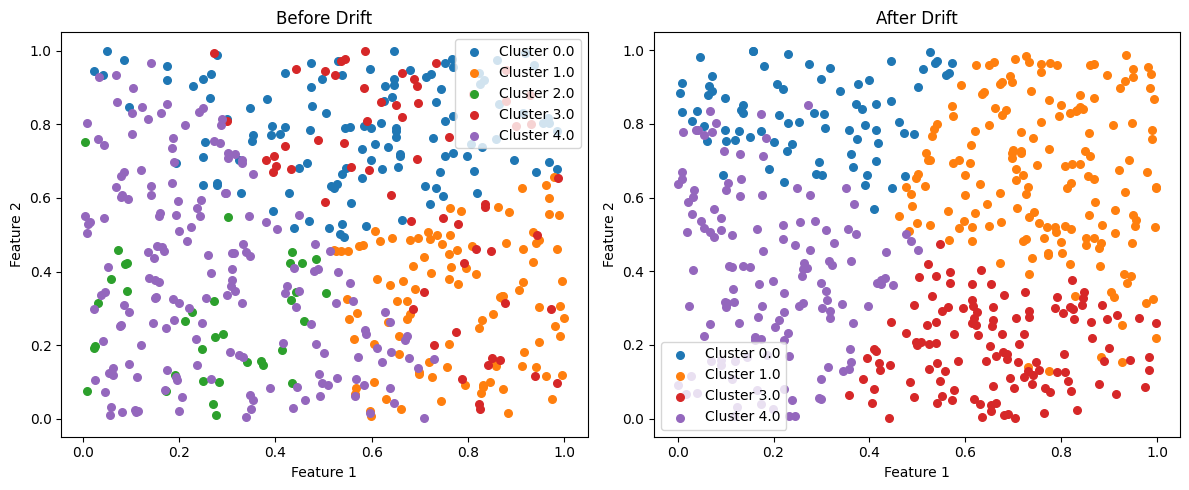

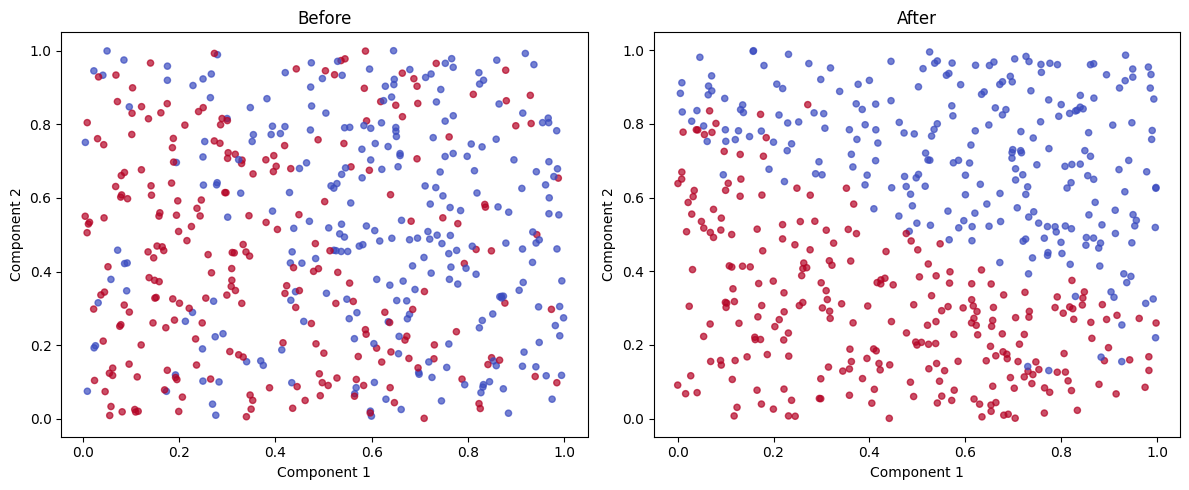

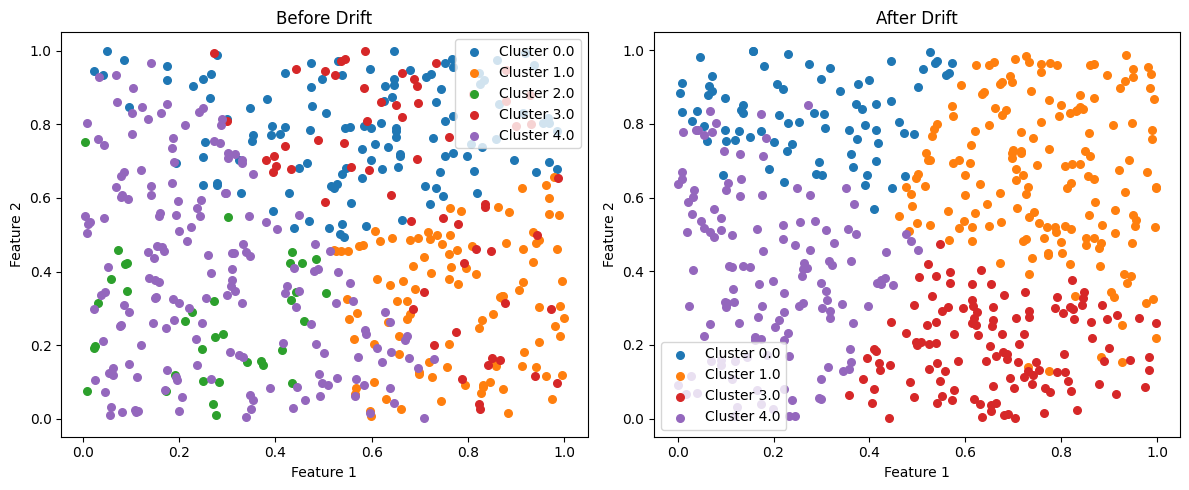

In [273]:
X_before, y_before = data_before
X_after, y_after = data_after

plot_drift_clustered(X_before, X_after, clusters_old, clusters_new)
plot_final_comparison(X_before, X_after, y_before, y_after, clusters_old, clusters_new)

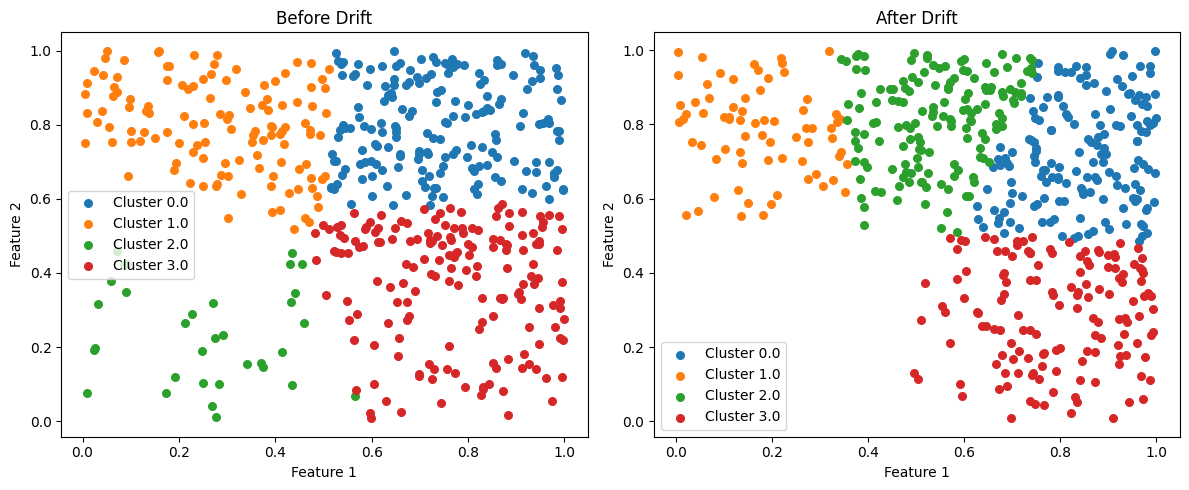

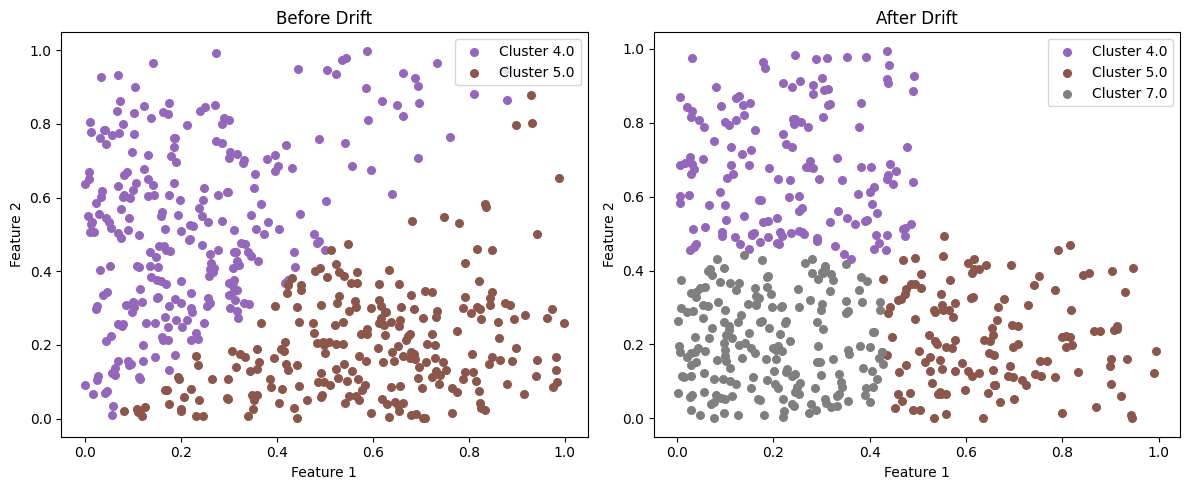

In [270]:
mask0 = y_before == 0 # niebieski
mask1 = y_before == 1 # czerwony

mask_after0 = y_after == 0
mask_after1 = y_after == 1

for m_b, m_a in [(mask0, mask_after0), (mask1, mask_after1)]:
    plot_drift_clustered(X_before[m_b], X_after[m_a], clusters_old[m_b], clusters_new[m_a])

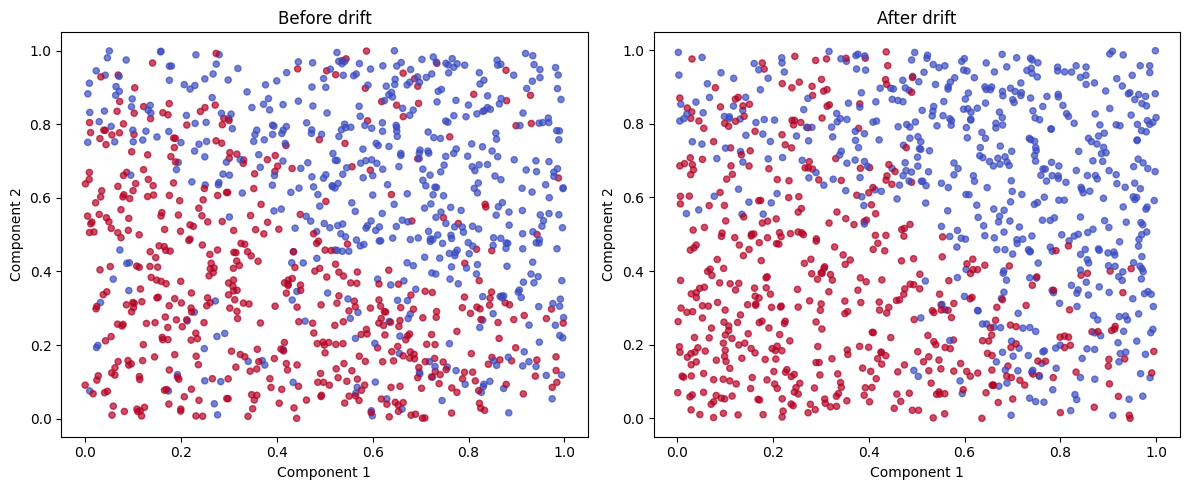

In [195]:
plot_drift(X_before, y_before, X_after, y_after, "Before drift", "After drift")

## **7. Model training and drift detection with ADWIN** ##

In [23]:
# TODO

In [23]:
n = 1000
X, y = [], []

for x, label in stream_SEA.take(n):
    X.append([x[i] for i in x.keys()])
    y.append(label)

Drift detected at sample 511


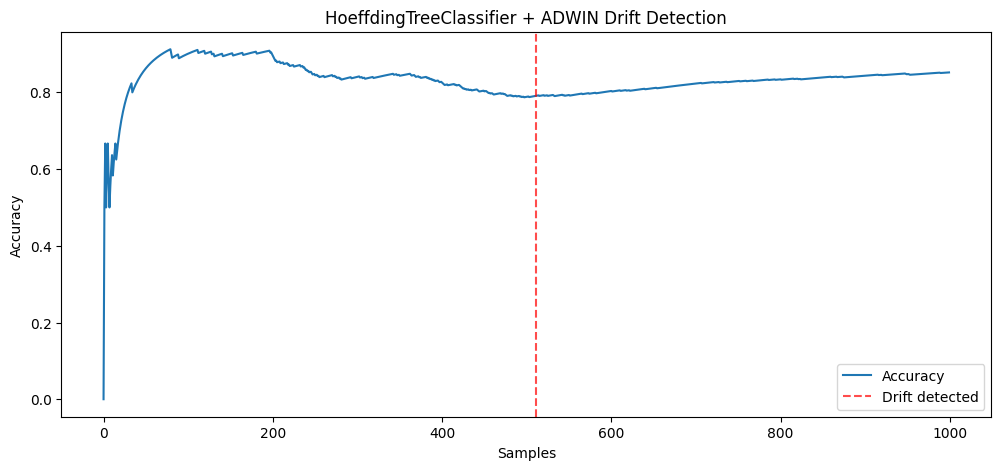

In [24]:
adwin = ADWIN()
model = tree.HoeffdingTreeClassifier()
metric = metrics.Accuracy()

accuracies = []
drift_points = []

for i, (x, y) in enumerate(stream_Hyperplane.take(n)):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)

    metric.update(y, y_pred)
    accuracies.append(metric.get())

    error = int(y_pred is not None and y != y_pred)
    adwin.update(error)

    if adwin.drift_detected:
        drift_points.append(i)
        print(f"Drift detected at sample {i}")

# 6. Plot results
plt.figure(figsize=(12,5))
plt.plot(accuracies, label="Accuracy")
for dp in drift_points:
    plt.axvline(dp, color="red", linestyle="--", alpha=0.7, label="Drift detected" if dp == drift_points[0] else "")
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.title("HoeffdingTreeClassifier + ADWIN Drift Detection")
plt.legend()
plt.show()

To jest tak na szybko robione. Trzeba tak zrobic zeby dzialalo tez dla SEA